In [1]:
from basicpy import BaSiC
import numpy as np

import zarr
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
path = '/u/home/f/f7xiesnm/project-zipursky/data/hold/lt172/r1_export.n5'

zarr_data = zarr.open(store=zarr.N5Store(path), mode='r')
images_s3 = zarr_data[f'/c0/s3'][100:200, :,:]
print(images_s3.shape)

images = zarr_data[f'/c0/s4'][...]
images.shape

(100, 455, 456)


(187, 227, 228)

In [3]:
images    = images.astype(np.float16) # then save back as uint16
images_s3 = images_s3.astype(np.float16)

images    = np.clip(images   -90, 0, None)
images_s3 = np.clip(images_s3-90, 0, None)

<Axes: ylabel='Count'>

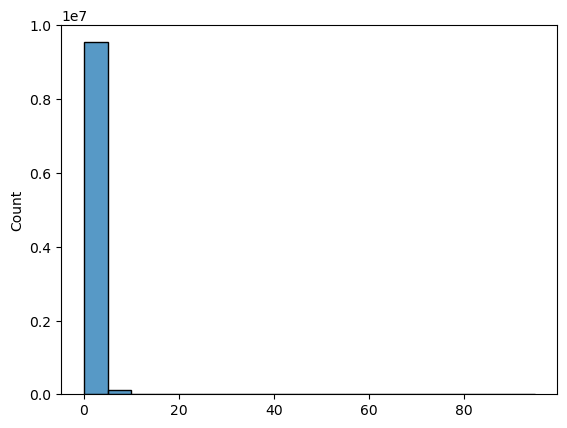

In [4]:
sns.histplot(np.ravel(images), bins=np.arange(0, 100, 5))

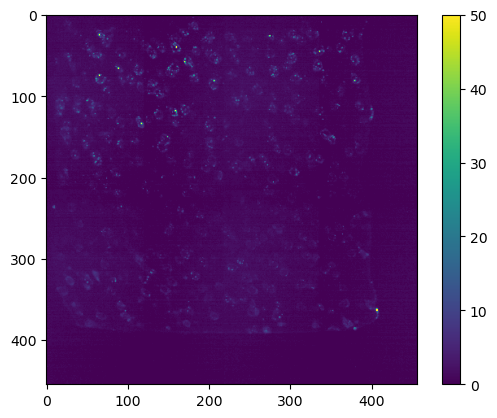

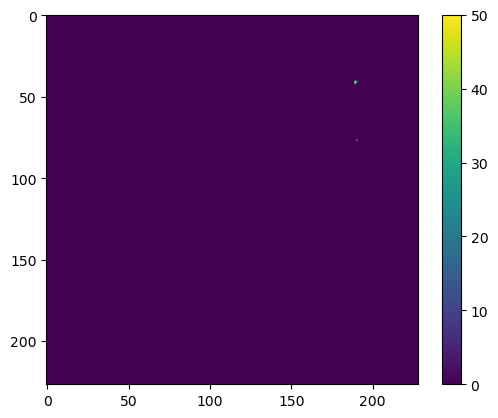

In [5]:
# vmin, vmax = 90, 100
vmin, vmax = 0, 50

plt.imshow(images_s3[50*2-100], vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()
plt.imshow(images[0], vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

In [6]:
%%time
basic = BaSiC(get_darkfield=True, smoothness_flatfield=1)
basic.fit(images)

Reweighting did not converge.


CPU times: user 1min 50s, sys: 13.6 s, total: 2min 4s
Wall time: 58.5 s


In [7]:
%%time
images_transformed = (images - basic.darkfield[np.newaxis])/ basic.flatfield[np.newaxis]

CPU times: user 65.9 ms, sys: 26.2 ms, total: 92 ms
Wall time: 87.3 ms


In [8]:
from scipy.ndimage import zoom

df_s3 = zoom(basic.darkfield, 2)
ff_s3 = zoom(basic.flatfield, 2)
df_s3 = np.pad(df_s3, ((0,1), (0,0)), constant_values=0)
ff_s3 = np.pad(ff_s3, ((0,1), (0,0)), constant_values=1)
df_s3.shape, ff_s3.shape

((455, 456), (455, 456))

In [9]:
images_trans_s3 = (images_s3 - df_s3[np.newaxis])/ ff_s3[np.newaxis]

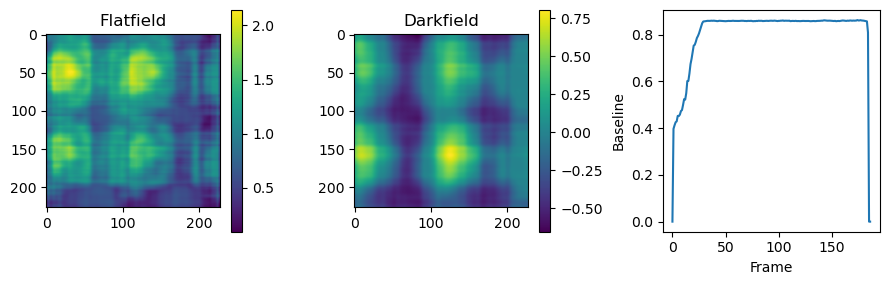

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
im = axes[0].imshow(basic.flatfield)
fig.colorbar(im, ax=axes[0])
axes[0].set_title("Flatfield")
im = axes[1].imshow(basic.darkfield)
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Darkfield")
axes[2].plot(basic.baseline)
axes[2].set_xlabel("Frame")
axes[2].set_ylabel("Baseline")
fig.tight_layout()

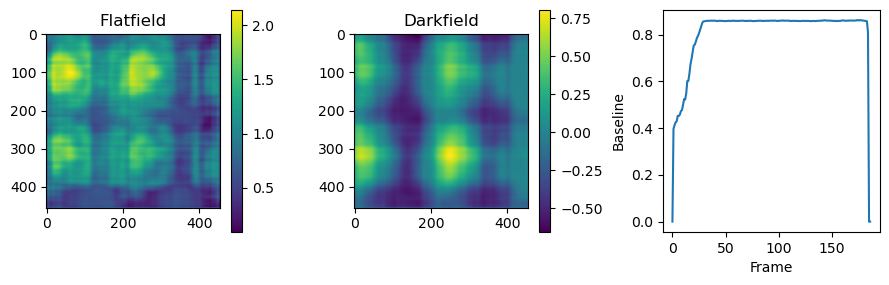

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
im = axes[0].imshow(ff_s3)
fig.colorbar(im, ax=axes[0])
axes[0].set_title("Flatfield")
im = axes[1].imshow(df_s3)
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Darkfield")
axes[2].plot(basic.baseline)
axes[2].set_xlabel("Frame")
axes[2].set_ylabel("Baseline")
fig.tight_layout()

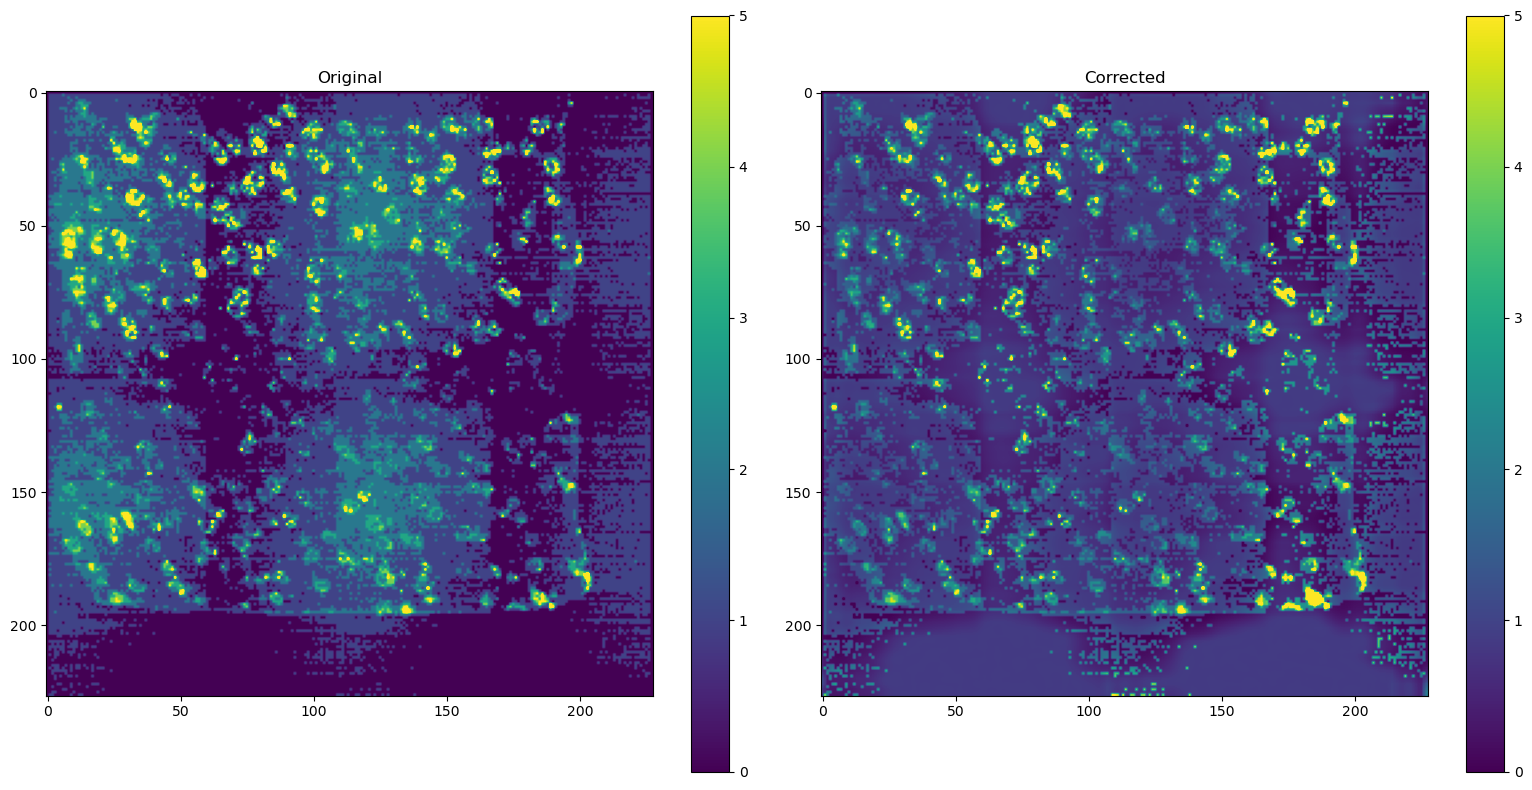

In [12]:
i = 50
vmin = np.percentile(images[i], 5)
vmax = np.percentile(images[i], 99)

fig, axes = plt.subplots(1, 2, figsize=(16,8))
im = axes[0].imshow(images[i], vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[0])
axes[0].set_title("Original")
im = axes[1].imshow(images_transformed[i], vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Corrected")
fig.tight_layout()

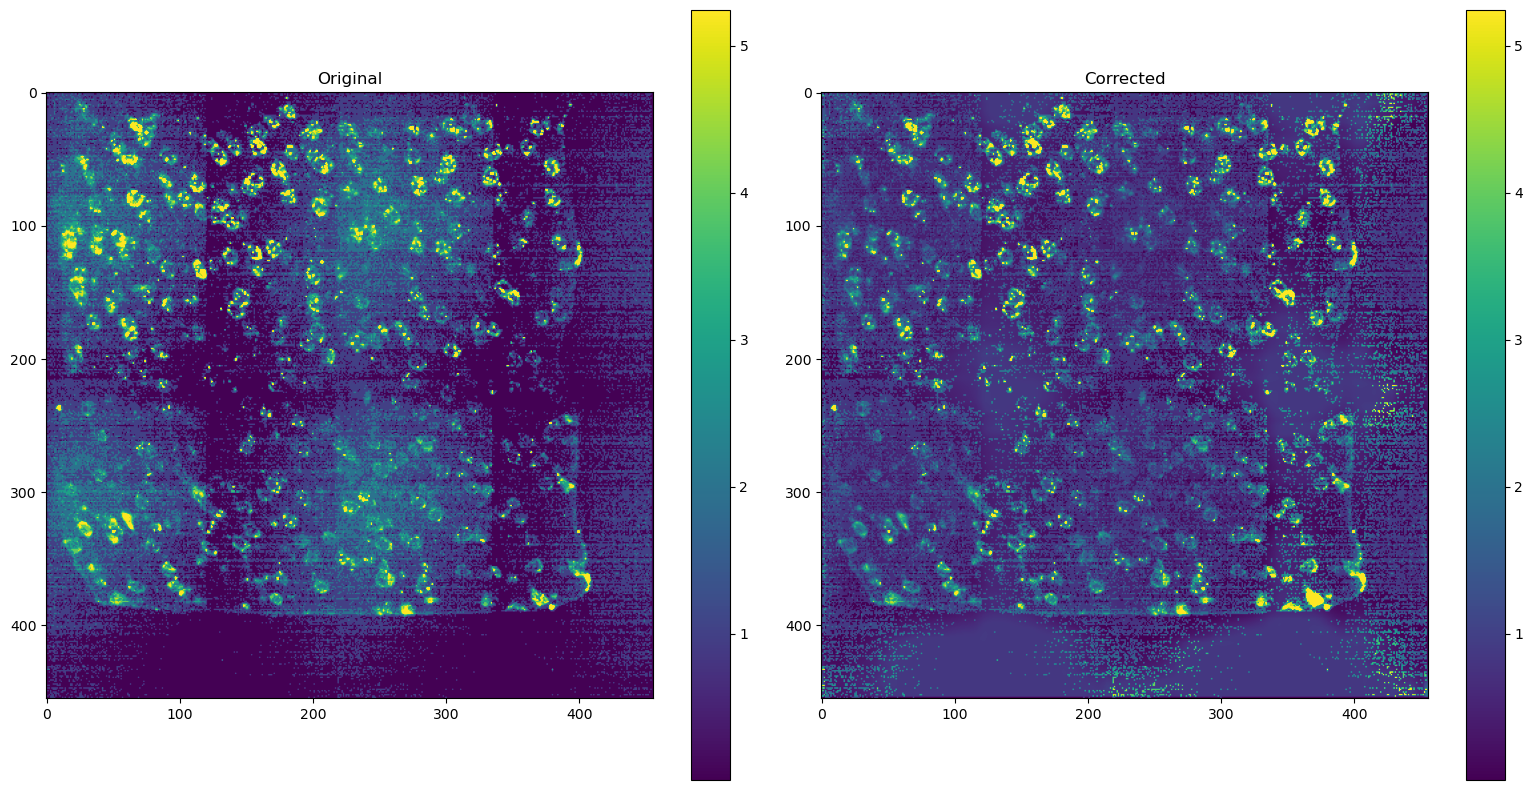

In [13]:
i = 0 
vmin = np.percentile(images_trans_s3[i], 5)
vmax = np.percentile(images_trans_s3[i], 99)

fig, axes = plt.subplots(1, 2, figsize=(16,8))
im = axes[0].imshow(images_s3[i], vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[0])
axes[0].set_title("Original")
im = axes[1].imshow(images_trans_s3[i], vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Corrected")
fig.tight_layout()